# Fit *Chandra* HETG data with a powerlaw

This notebook gives an example of fitting *Chandra* HETG data with a simple power law model, using real spectrum files downloaded from *tgcat*.  We use the methods outlined in `ParTest_ProofOfConcept.ipynb`

We will fit the spectrum of the well-known blazar Mrk 421, which is frequently used as a *Chandra* calibration source.  This tutorial uses the data from ObsId 15477 obtained from tgcat (http://tgcat.mit.edu/)

Once you have downloaded the data files, unpack and unzip all the files in your directory of choice (`DATA_DIR`).  Don't forget to **modify the `DATA_DIR` string below** before running this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
import scipy.stats
from scipy.special import gammaln as scipy_gammaln
from scipy.optimize import minimize

import astropy.units as u

import pyxsis
from pyxsis.io import load_chandra_hetg

%matplotlib inline

In [2]:
DATA_DIR = os.environ['HOME'] + "/temp/test-pyxsis/tests/data"
mrk_dir  = DATA_DIR + "/17385/"
mrk_heg1_file = mrk_dir + "heg_1.pha"

## Load the spectrum

In [3]:
heg_p1 = pyxsis.io.load_chandra_hetg(DATA_DIR + "/17385/heg_1.pha", 
                                     arf=DATA_DIR + "/17385/heg_1.arf",
                                     rmf=DATA_DIR + "/17385/heg_1.rmf")

Assigning rmf /Users/liac/temp/test-pyxsis/tests/data/17385/heg_1.rmf
Assigning arf /Users/liac/temp/test-pyxsis/tests/data/17385/heg_1.arf


In [4]:
# Notice only the 0.3-8 keV spectral region
heg_p1.notice_range(0.3*u.keV, 8.0*u.keV)

# group the spectrum
#pyxsis.group_mincounts(heg_p1, 30) ## Uncomment to see example with grouped spectra

[]

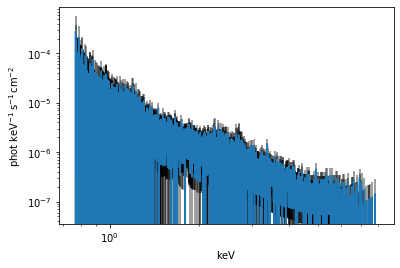

In [5]:
# Plot the spectrum
ax = plt.subplot(111)
pyxsis.plot_unfold(ax, heg_p1)
plt.loglog()

## Set up the model

In [6]:
# I will fit this spectrum with a powerlaw
my_pl = pyxsis.models.PowerLaw(norm=np.power(10.0, -0.5), phoindex=2.5)

# Note that the model is completely independent of my spectrum. 
# So you will need to write some infrastructure in order to match 
# the energy binning from the loaded spectrum.
def evaluate_my_powerlaw(spectrum):
    # Because I know that Chandra HETG files have angstroms for bin_lo and bin_hi,
    # I know I need to swap hi and low when I am converting to energy
    elo = spectrum.bin_hi.to('keV', equivalencies=u.spectral()).value
    ehi = spectrum.bin_lo.to('keV', equivalencies=u.spectral()).value 

    mflux = my_pl.calculate(elo, ehi)
    model_counts = spectrum.evaluate_model(mflux)
    return model_counts

model_counts = evaluate_my_powerlaw(heg_p1)

In [7]:
# A function that allows me to plot the model
def plot_mymodel_pars(ax, spectrum, pars=None, xunit='keV'):
    pyxsis.plot_counts(ax, spectrum, xunit=xunit) # standard pyxsis plot
    
    # I need the binning information, if my spectrum is grouped
    # So I can overlay it on the correct X and Y axis
    xlo, xhi, y, yerr = spectrum.binned_counts(bin_unit=xunit)
    xcen = 0.5 * (xlo + xhi)

    # Note that if the input parameters violate the limits,
    # then the endpoints (limits) of the model will be selected by default
    if pars is not None:
        my_pl.update({'norm': np.power(10.0, pars[0]),
                      'phoindex': pars[1]})
        binned_model_counts = evaluate_my_powerlaw(spectrum)
    else:
        binned_model_counts = spectrum.bin_model_counts()

    ax.plot(xcen, spectrum.bin_model_counts(), color='r')
    return

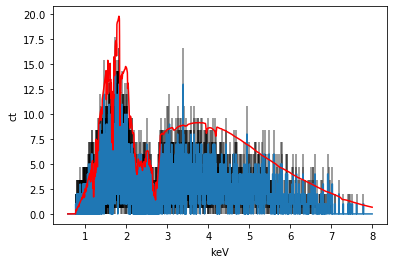

In [8]:
ax = plt.subplot(111)
plot_mymodel_pars(ax, heg_p1, pars=[-0.5, 2.5], xunit='keV')

## Set up the fit statistic

Using Poisson statistics, the probability of getting a certain number of counts ($x$) given an expected model value of $m$ is:

$$ P (x | m) = \frac{m^x e^{-m}}{x!} $$

The log likelihood function is therefore

$$ \ln L = \ln \Pi_i P(x_i | m_i) = \Sigma_i \left[ x_i \ln m_i - m_i - \ln (x_i !) \right] = -K + \Sigma_i (x_i \ln m_i - m_i) $$

In this case, $K$ is a constant and can be ignored.

In order to *maximize* the likelihood, we want to maximize the value

$$ C' = \Sigma_i (x_i \ln m_i - m_i) $$

This is related to the well-known Cash statistic:

$$ C \equiv -2 \ln L = 2 \Sigma_i (m_i - x_i \ln m_i)  $$

so that $C' = -C / 2$

In [9]:
def loglikelihood(pars):
    # check that the parameters fall within the model limits
    lognorm, pi = pars
    if not my_pl.check_par_lims({'norm': np.power(10.0, lognorm), 'phoindex': pi}):
        return -np.inf
    
    # If the parameters are okay, do the things
    else:
        my_pl.update({'norm': np.power(10.0, lognorm),
                      'phoindex': pi})
        ymodel = evaluate_my_powerlaw(heg_p1)
        xlo, xhi, ycts, ycts_err = heg_p1.binned_counts()
        ydata = ycts.value # <-- for getting around an Astropy Units issue
        
        # compute the log-likelihood
        # BEWARE -- this has a very crude treatement of zero values
        cvals   = np.zeros(len(ymodel))
        ii      = (ymodel != 0.0)
        cvals[ii] = ydata[ii] * np.log(ymodel[ii]) - ymodel[ii]
        loglike = np.sum(cvals)
            
        if np.isfinite(loglike):
            return loglike
        else:
            return -np.inf
    return result

def cash(pars):
    result = loglikelihood(pars)
    return -result/2.0

In [10]:
par0 = [-0.5, 2.5] # Log10(Norm) and Photon Index for the power law
cash(par0)

5081.728012851076

## Now select and run the optimizer

In [11]:
res = scipy.optimize.minimize(cash, par0)
print("Best fit parameters:", res.x)

/usr/local/anaconda/envs/pyxsis-dev/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best fit parameters: [-1.02201512  2.34945615]


In [12]:
## Here's a convenience function for printing Model information
my_pl.info()


--------------------------------------------------------------------------------
PowerLaw
Parameter      Value     Limits                 Unit      
--------------------------------------------------------------------------------
norm      0.09505717055604389         0         0	s^-1 cm^-2
phoindex  2.349456146478493     -10.0     -10.0	          


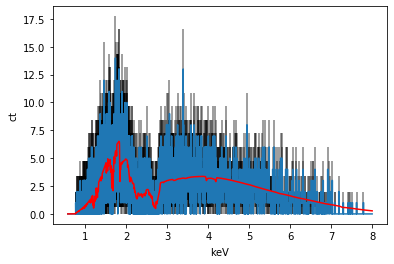

In [13]:
# Plot the results

ax = plt.subplot(111)
plot_mymodel_pars(ax, heg_p1, pars=res.x)

## Method 2 - Set up model and statistics together

To keep everything working together smoothly, you could create a Class to hold all of the relevant information. This shows an example of that.

In [15]:
class PowerlawPoissonFit(object):
    def __init__(self, filename, **kwargs):
        self.xspec = load_chandra_hetg(filename) # load the X-ray spectrum
        self.model = pyxsis.models.PowerLaw()
    
    def set_model_pars(self, pars):
        lognorm, pi = pars
        self.model.update({'norm': np.power(10.0, lognorm),
                           'phoindex': pi})
        
    # Model counts histogram
    def model_chist(self, pars):
        # WARNING: elo and ehi *must* be numpy array inputs to model.calculate
        elo = self.xspec.bin_hi.to('keV', equivalencies=u.spectral()).value
        ehi = self.xspec.bin_lo.to('keV', equivalencies=u.spectral()).value
        self.set_model_pars(pars)
        mflux  = self.model.calculate(elo, ehi)
        result = self.xspec.evaluate_model(mflux)
        return result
    
    def loglikelihood(self, pars):
        # check that the parameters fall within the model limits
        lognorm, pi = pars
        if not self.model.check_par_lims({'norm': np.power(10.0, lognorm), 'phoindex': pi}):
            return -np.inf
        # If the parameters are okay, do the things
        else:
            ymodel = self.model_chist(pars)
            xlo, xhi, ycts, ycts_err = self.xspec.binned_counts()
            ydata = ycts.value # avoids an Astropy units issue
            # compute the log-likelihood
            # BEWARE -- this has a very crude treatement of zero values
            cvals   = np.zeros(len(ymodel))
            ii      = (ymodel != 0.0)
            cvals[ii] = ydata[ii] * np.log(ymodel[ii]) - ymodel[ii]
            loglike = np.sum(cvals)
            
            if np.isfinite(loglike):
                return loglike
            else:
                return -np.inf
        return result

    def cash(self, pars):
        result = self.loglikelihood(pars)
        return -result/2.0
    
    ## Get residuals on the best fit
    def mod_residuals(self, pars):
        mcounts = self.model_chist(pars)
        cts_err = np.sqrt(self.xspec.counts)
        result  = np.zeros(len(self.xspec.counts))
        ii      = (cts_err != 0.0)
        result[ii] = (mcounts[ii] - self.xspec.counts[ii].value)/cts_err[ii].value
        return result


In [16]:
mrkfitter = PowerlawPoissonFit(mrk_heg1_file)

Assigning rmf /Users/liac/temp/test-pyxsis/tests/data/17385/heg_1.rmf
Assigning arf /Users/liac/temp/test-pyxsis/tests/data/17385/heg_1.arf


**Plot the data so we know it loaded okay**

Try switching the `xunit` keyword between 'keV' and 'Angstrom'

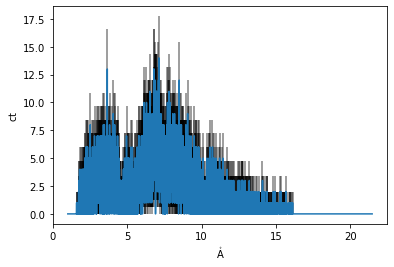

In [17]:
ax = plt.subplot(111)
pyxsis.plot_counts(ax, mrkfitter.xspec, xunit='Angstrom')

**Do a rough estimate of the flux spectrum by "unfolding" the counts histogram with the telescope response**

(0.5, 8.0)

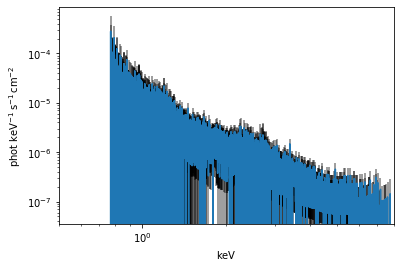

In [18]:
ax = plt.subplot(111)
pyxsis.plot_unfold(ax, mrkfitter.xspec, xunit='keV')
plt.loglog()
plt.xlim(0.5,8.0)

## Start fitting

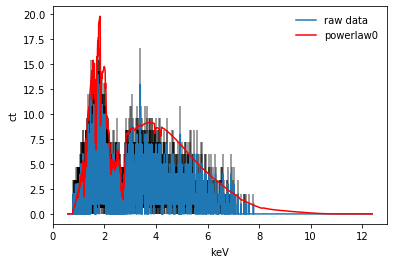

In [19]:
par0 = [-0.5, 2.5]  # Some starting parameters
mod0 = mrkfitter.model_chist(par0)

ax = plt.subplot(111)
pyxsis.plot_counts(ax, mrkfitter.xspec, xunit='keV', label='raw data')
plt.plot(mrkfitter.xspec.bmid_keV, mod0, 'r', label='powerlaw0')
plt.legend(loc='upper right', frameon=False)

In [20]:
mrkfitter.loglikelihood(par0)

-10208.151898036589

In [21]:
mrkfitter.cash(par0)

5104.0759490182945

Now run scipy.optimize.minimize on the Cash statistic

In [23]:
res = scipy.optimize.minimize(mrkfitter.cash, par0)
print("Best fit parameters:", res.x)
mrkfitter.model.info()

/usr/local/anaconda/envs/pyxsis-dev/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best fit parameters: [-1.01964232  2.35970536]

--------------------------------------------------------------------------------
PowerLaw
Parameter      Value     Limits                 Unit      
--------------------------------------------------------------------------------
norm      0.0955779436271818         0         0	s^-1 cm^-2
phoindex  2.3597053770528724     -10.0     -10.0	          
